# DeepTCN model

There is an example of probabilistic forecasting using TCN model that very close to DeepTCN described in https://arxiv.org/abs/1906.04397

In [1]:
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt

# run torch models on CPU
torch_kwargs = {"pl_trainer_kwargs": {"accelerator": "cpu"}}

## Variable noise series

<Axes: xlabel='time'>

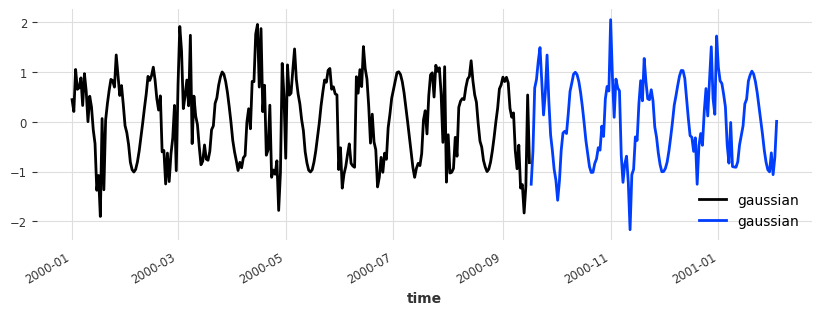

In [3]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02)
    + tg.constant_timeseries(length=length, value=1)
) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

plt.figure(figsize=(10, 3))
target_train.plot()
target_val.plot()

In [4]:
deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=20,
    kernel_size=2,
    num_filters=4,
    dilation_base=2,
    dropout=0,
    random_state=0,
    likelihood=GaussianLikelihood(),
    **torch_kwargs,
)

deeptcn.fit(target_train, past_covariates=covariates)

Training: 0it [00:00, ?it/s]

TCNModel(kernel_size=2, num_filters=4, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=20, random_state=0, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), pl_trainer_kwargs={'accelerator': 'cpu'})

Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='time'>

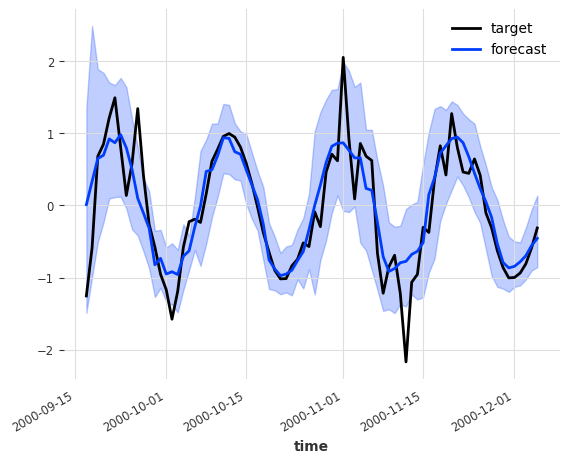

In [5]:
pred = deeptcn.predict(80, past_covariates=covariates, num_samples=100)
target_val.slice_intersect(pred).plot(label="target")
pred.plot(label="forecast")

## Daily energy production

<Axes: xlabel='time'>

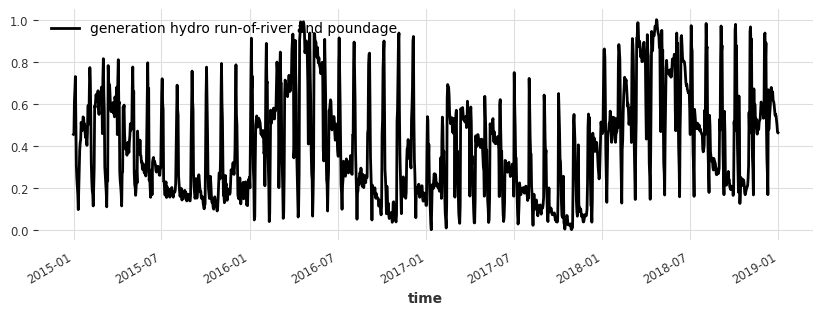

In [6]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate (no scaling required, as one-hot-encoded)
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)

plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [7]:
model_name = "TCN_test"
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood(),
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **torch_kwargs,
)

deeptcn.fit(
    series=train_en_transformed,
    past_covariates=day_series,
    val_series=val_en_transformed,
    val_past_covariates=day_series,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TCNModel(kernel_size=3, num_filters=4, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, batch_size=32, n_epochs=20, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=300, output_chunk_length=30, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=TCN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'})

Let's load the model at the best performing state

In [8]:
deeptcn = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

Now we perform historical forecasts:
- we start at the earliest possible prediction start point (`start=None`)
- each prediction will have length `forecast_horizon=30`.
- the next prediction will start `stride=30` points ahead
- we keep all predicted values from each forecast (`last_points_only=False`) 
- continue until we run out of input data

In the end we concatenate the historical forecasts to get a single continuous (on time axis) time series

In [11]:
backtest_en = deeptcn.historical_forecasts(
    series=val_en_transformed,
    past_covariates=day_series,
    num_samples=500,
    forecast_horizon=30,
    stride=30,
    last_points_only=False,
    retrain=False,
    verbose=False,
)
backtest_en = concatenate(backtest_en)

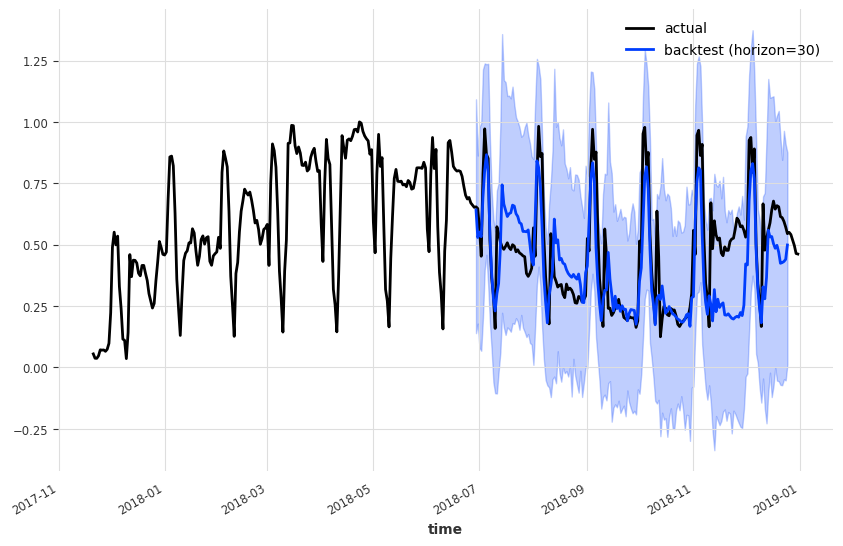

In [10]:
plt.figure(figsize=(10, 6))
val_en_transformed[len(backtest_en) - 100 :].plot(label="actual")
backtest_en.plot(label="backtest (horizon=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()